# EfficientNet training from scratch on car damage severity dataset

This this notebook, we implement EfficientNet from scratch and train it on car damage severity dataset. The dataset is can be found on Kaggle: https://www.kaggle.com/datasets/prajwalbhamere/car-damage-severity-dataset

In [1]:
import torch
import torch.nn as nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np
from torchinfo import summary
from tqdm import tqdm
from math import ceil

c:\Users\bader\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
imgs_path = Path("../../data/car-damage/data3a/")
class_to_idx = {p.name: i for i, p in enumerate(list((imgs_path/ "training").iterdir()))}
idx_to_class = {v:k for k,v in class_to_idx.items()}

In [4]:
print(class_to_idx)

{'01-minor': 0, '02-moderate': 1, '03-severe': 2}


In [5]:
class CarDamageDataset(Dataset):
    def __init__(self, imgs_path, transform = None) -> None:
        self.imgs_path = imgs_path
        self.transform = transform

        self.files_paths = [p for p in imgs_path.glob("**/*") if p.is_file()]

    def __len__(self):
        return len(self.files_paths)
    
    def __getitem__(self, index):
        file_path = self.files_paths[index]
        img = Image.open(file_path).convert('RGB')
        label = file_path.parent.name
        label = class_to_idx[label]

        if self.transform:
            img = self.transform(img)
        
        return img, label


In [6]:
def get_loaders(imgs_path, batch_size, val_split = 0.1, shuffle = True, random_seed=42, input_size=260):

    train_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

    
    train_dataset = CarDamageDataset(imgs_path/ "training", train_transform)
    val_dataset = CarDamageDataset(imgs_path/ "training", val_transforms)
    test_dataset = CarDamageDataset(imgs_path/ "validation", val_transforms)

    len_train = int(np.floor(len(train_dataset) * (1 - val_split)))
    len_val = len(train_dataset) - len_train

    indices = list(range(len(train_dataset)))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, val_idx = indices[:len_train], indices[len_train:]

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size, train_sampler)
    val_loader = DataLoader(val_dataset, batch_size, val_sampler)
    test_loader = DataLoader(test_dataset, batch_size)
                               
    return train_loader, val_loader, test_loader


Display images from the dataset

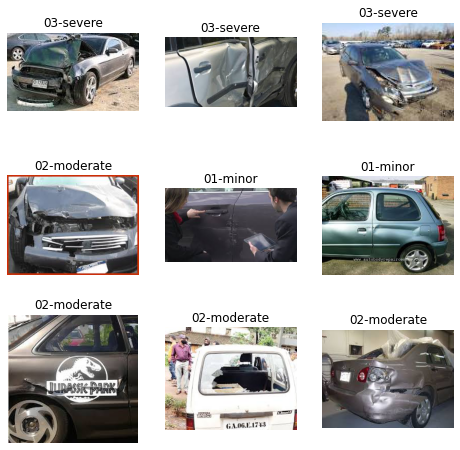

In [7]:
ds = CarDamageDataset(imgs_path/ "training")

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, rows * cols + 1):
    sample_idx = torch.randint(len(ds), size=(1,)).item()
    img, label = ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(idx_to_class[label])
    plt.axis("off")
    plt.imshow(img)

plt.show()

Create data loaders

In [8]:
batch_size = 32

In [9]:
train_loader, val_loader, test_loader = get_loaders(imgs_path, batch_size, input_size=260)

## Create EfficientNet

In [10]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5], 
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 2, 3],
]

phi_values = {
    # phi_value, resolution, drop_rate
    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.3),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1) -> None:
        super().__init__()

        self.cnn = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU()

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))


class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim) -> None:
        super().__init__()

        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), 
            nn.Conv2d(in_channels, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, kernel_size=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)


class InvertedResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        expand_ratio,
        reduction=4,
        survival_prob=0.8
    ) -> None:
        super().__init__()

        self.survival_prob = survival_prob
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = ConvBlock(
                in_channels, hidden_dim, kernel_size=1, stride=1, padding=0
            )

        self.conv = nn.Sequential(
            ConvBlock(hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob

        return torch.div(x, self.survival_prob) * binary_tensor


    def forward(self, inputs):

        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)
        

class EfficientNet(nn.Module):
    def __init__(self, version, num_classes) -> None:
        super().__init__()

        width_factor, depth_factor, droptout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)

        self.features = self.create_features(width_factor, depth_factor, last_channels)

        self.classifier = nn.Sequential(
            nn.Dropout(droptout_rate),
            nn.Linear(last_channels, num_classes)
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]

        width_factor = beta ** phi
        depth_factor = alpha ** phi

        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [ConvBlock(3, channels, kernel_size=3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4* ceil(int(channels * width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)
            
            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride if layer == 0 else 1,
                        padding=kernel_size // 2,
                        expand_ratio=expand_ratio)
                )

                in_channels = out_channels

        
        features.append(ConvBlock(
            in_channels, last_channels, kernel_size=1, stride=1, padding=0
        ))

        features = nn.Sequential(*features)

        return features

    def forward(self, x):

        x = self.features(x)
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)

        return x



In [11]:
num_classes = len(class_to_idx)

In [12]:
model = EfficientNet("b2", num_classes).to(device)

In [13]:
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 3]                    --
├─Sequential: 1-1                                       [1, 1408, 4, 4]           --
│    └─ConvBlock: 2-1                                   [1, 35, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 35, 112, 112]         945
│    │    └─BatchNorm2d: 3-2                            [1, 35, 112, 112]         70
│    │    └─SiLU: 3-3                                   [1, 35, 112, 112]         --
│    └─InvertedResidualBlock: 2-2                       [1, 20, 112, 112]         --
│    │    └─Sequential: 3-4                             [1, 20, 112, 112]         1,728
│    └─InvertedResidualBlock: 2-3                       [1, 20, 112, 112]         --
│    │    └─Sequential: 3-5                             [1, 20, 112, 112]         885
│    └─InvertedResidualBlock: 2-4                      

## Train model

In [14]:
num_epochs = 30
learning_rate = 0.005
weight_decay_rate = 0.0005
momentum = 0.9

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate, momentum=momentum)

In [16]:
total_steps = len(train_loader)

In [17]:
for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print(f"Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}")

    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)

            correct += (preds == labels).sum()
            total += labels.size(0)

        acc = 100 * correct / total

    print(f"Validation accuracy: {acc:.2f}%")

100%|██████████| 44/44 [00:17<00:00,  2.52it/s]


Epoch [1/30], loss: 1.2097
Validation accuracy: 36.15%


100%|██████████| 44/44 [00:15<00:00,  2.82it/s]


Epoch [2/30], loss: 1.5989
Validation accuracy: 35.72%


100%|██████████| 44/44 [00:16<00:00,  2.65it/s]


Epoch [3/30], loss: 1.0471
Validation accuracy: 41.50%


100%|██████████| 44/44 [00:18<00:00,  2.43it/s]


Epoch [4/30], loss: 0.9021
Validation accuracy: 41.94%


100%|██████████| 44/44 [00:16<00:00,  2.70it/s]


Epoch [5/30], loss: 1.2232
Validation accuracy: 49.02%


100%|██████████| 44/44 [00:17<00:00,  2.58it/s]


Epoch [6/30], loss: 0.8930
Validation accuracy: 49.17%


100%|██████████| 44/44 [00:17<00:00,  2.58it/s]


Epoch [7/30], loss: 0.9309
Validation accuracy: 54.01%


100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


Epoch [8/30], loss: 1.0154
Validation accuracy: 49.82%


100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


Epoch [9/30], loss: 1.0420
Validation accuracy: 54.59%


100%|██████████| 44/44 [00:17<00:00,  2.57it/s]


Epoch [10/30], loss: 0.8885
Validation accuracy: 52.35%


100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


Epoch [11/30], loss: 1.4476
Validation accuracy: 57.48%


100%|██████████| 44/44 [00:17<00:00,  2.56it/s]


Epoch [12/30], loss: 1.1610
Validation accuracy: 56.54%


100%|██████████| 44/44 [00:17<00:00,  2.50it/s]


Epoch [13/30], loss: 0.7684
Validation accuracy: 55.31%


100%|██████████| 44/44 [00:16<00:00,  2.64it/s]


Epoch [14/30], loss: 1.2079
Validation accuracy: 57.77%


100%|██████████| 44/44 [00:16<00:00,  2.70it/s]


Epoch [15/30], loss: 1.1683
Validation accuracy: 56.98%


100%|██████████| 44/44 [00:16<00:00,  2.74it/s]


Epoch [16/30], loss: 0.8063
Validation accuracy: 61.82%


100%|██████████| 44/44 [00:16<00:00,  2.67it/s]


Epoch [17/30], loss: 0.8201
Validation accuracy: 59.87%


100%|██████████| 44/44 [00:16<00:00,  2.73it/s]


Epoch [18/30], loss: 1.9598
Validation accuracy: 61.24%


100%|██████████| 44/44 [00:16<00:00,  2.61it/s]


Epoch [19/30], loss: 0.5139
Validation accuracy: 64.35%


100%|██████████| 44/44 [00:16<00:00,  2.61it/s]


Epoch [20/30], loss: 0.8046
Validation accuracy: 63.56%


100%|██████████| 44/44 [00:16<00:00,  2.70it/s]


Epoch [21/30], loss: 0.9463
Validation accuracy: 61.75%


100%|██████████| 44/44 [00:17<00:00,  2.53it/s]


Epoch [22/30], loss: 0.8167
Validation accuracy: 65.51%


100%|██████████| 44/44 [00:16<00:00,  2.61it/s]


Epoch [23/30], loss: 0.5366
Validation accuracy: 68.26%


100%|██████████| 44/44 [00:16<00:00,  2.63it/s]


Epoch [24/30], loss: 0.6232
Validation accuracy: 70.79%


100%|██████████| 44/44 [00:16<00:00,  2.63it/s]


Epoch [25/30], loss: 1.0271
Validation accuracy: 72.09%


100%|██████████| 44/44 [00:16<00:00,  2.62it/s]


Epoch [26/30], loss: 0.6829
Validation accuracy: 71.66%


100%|██████████| 44/44 [00:16<00:00,  2.65it/s]


Epoch [27/30], loss: 0.6711
Validation accuracy: 74.55%


100%|██████████| 44/44 [00:17<00:00,  2.58it/s]


Epoch [28/30], loss: 1.6323
Validation accuracy: 72.96%


100%|██████████| 44/44 [00:16<00:00,  2.71it/s]


Epoch [29/30], loss: 0.5741
Validation accuracy: 74.33%


100%|██████████| 44/44 [00:17<00:00,  2.57it/s]


Epoch [30/30], loss: 0.7242
Validation accuracy: 78.16%


In [19]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print(f'Test accuracy: {100 * correct / total:.2f} %')

Test accuracy: 57.26 %
